## Import libraries

In [1]:
import pandas as pd
import numpy as np
import os
import random
from pdb import set_trace as bp
import matplotlib.pyplot as plt
from collections import defaultdict
from utils import plotGraph,plotLengthHistogram,plotHist,labelPlot

In [2]:
trainData = pd.read_csv('train.csv')
testData = pd.read_csv('test.csv')
trainData.dropna(inplace=True)
testData.dropna(inplace=True)

In [3]:
print "Number of training data: \t" + str( trainData.shape[0] )
print "Number of test data:     \t" + str( testData.shape[0] )

Number of training data: 	404287
Number of test data:     	2345790


In [4]:
trainData

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0
5,5,11,12,Astrology: I am a Capricorn Sun Cap moon and c...,"I'm a triple Capricorn (Sun, Moon and ascendan...",1
6,6,13,14,Should I buy tiago?,What keeps childern active and far from phone ...,0
7,7,15,16,How can I be a good geologist?,What should I do to be a great geologist?,1
8,8,17,18,When do you use シ instead of し?,"When do you use ""&"" instead of ""and""?",0
9,9,19,20,Motorola (company): Can I hack my Charter Moto...,How do I hack Motorola DCX3400 for free internet?,0


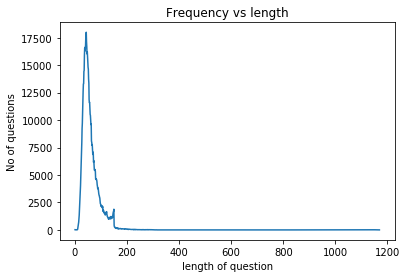

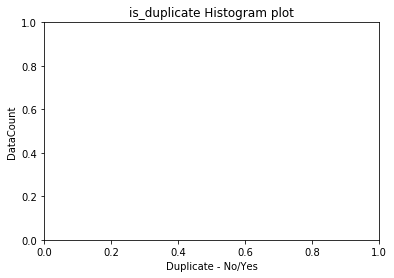

In [5]:
plotLengthHistogram(trainData)
plotHist(trainData['is_duplicate'],'Duplicate - No/Yes', 'DataCount','is_duplicate Histogram plot')

In [8]:
def getDictionaryLen(data):
    wordSet = set()
    for ques in data['question1']:
        for word in ques.strip().split():
            wordSet.add(word)
    for ques in data['question2']:
        for word in ques.strip().split():
            wordSet.add(word)
    print "Unique words in Training dataset: " + str(len(wordSet))
getDictionaryLen(trainData)

Unique words in Training dataset: 232531


In [8]:
# def getWordEmbedding( datapath = './data/', filename = 'glove.6B.100d.txt'):
datapath = './data/'
filename = 'glove.6B.100d.txt'
embeddingFilePath = os.path.join(datapath,filename )
embeddFileData = open(embeddingFilePath, 'r').readlines()
# print embeddingFilePath
# wordEmbedding = load

In [24]:
# def createEmbeddingDict():
embeddDict = defaultdict(list)

In [29]:
for line in embeddFileData:
    words = line.split()
    word = words[0]
    weights = np.zeros(100)
    for i in range(100):
        try:
            weights[i] = float(words[i+1])
        except:
            bp()
    embeddDict[word] = weights

In [30]:
embeddDict.keys()

['biennials',
 'verplank',
 'soestdijk',
 'woode',
 'mdbo',
 'sowell',
 'mdbu',
 'woods',
 'spiders',
 'mdbs',
 'mdbr',
 'woody',
 'trawling',
 'hwasung',
 'spidery',
 'regularize',
 'hennings',
 'canes',
 'canet',
 'caney',
 'yusaf',
 'chanthaburi',
 'igual',
 'comptuex',
 'caned',
 'mirisch',
 'kalecik',
 'rickman',
 'jacquemod',
 'ioannidis',
 'canel',
 'canem',
 'afikoman',
 'dra\xc5\xbea',
 'heliothis',
 'replacer',
 'pigment',
 'bogyman',
 'transvestism',
 'fuste',
 '\xc4\x91\xc6\xb0\xe1\xbb\x9dng',
 'seamier',
 'illtyd',
 'wooded',
 'shipworms',
 'boorstein',
 'grueling',
 'persita',
 'wooden',
 'i\xcc\x87kinci',
 'virtuosos',
 'altagracia',
 'salination',
 'wasescha',
 'troutwine',
 'gentzen',
 'immunities',
 'all-news',
 'two-and-a-half-story',
 'thrace',
 'maytham',
 'gaskets',
 'snuggles',
 'abdulwahab',
 '2.1-million',
 'deadheads',
 'pulavar',
 '266-megahertz',
 'consenting',
 'snuggled',
 'guntermann',
 'grandcourt',
 'usenet',
 'videodrome',
 'outfielders',
 'niepo\xc5\x

In [32]:
import pickle

with open('embeddDict_glove_6b_100d.pickle', 'wb') as handle:
    pickle.dump(embeddDict, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [33]:
with open('embeddDict_glove_6b_100d.pickle', 'rb') as handle:
    embeddDict2 = pickle.load(handle)

In [35]:
embeddDict.values()

[array([-0.049107 ,  1.0836   , -0.96898  , -0.1956   ,  0.5042   ,
         0.20568  ,  0.11316  , -0.27911  ,  0.25616  , -0.23222  ,
        -0.011899 , -0.84183  , -0.0075647, -0.19212  , -0.64505  ,
         0.14264  , -0.0040923,  1.0564   ,  0.51505  , -0.30537  ,
        -0.18885  ,  0.22644  ,  0.18101  ,  0.74606  ,  0.8864   ,
         0.18044  , -0.067711 , -0.0088145, -0.45453  , -0.33256  ,
        -0.38935  , -0.60575  , -0.13333  ,  0.10477  ,  0.016106 ,
         0.7391   ,  0.55728  , -0.31496  , -0.72784  , -0.32057  ,
         0.36874  ,  0.59379  , -0.23812  , -0.17137  ,  0.16075  ,
         0.30295  ,  0.50082  , -0.47355  , -0.082908 ,  0.25314  ,
         0.2779   , -0.35703  , -0.27447  , -0.67199  , -0.072644 ,
         1.1955   ,  0.17128  , -0.015494 , -0.41772  ,  0.25037  ,
        -0.35641  ,  1.0195   , -0.41484  ,  0.36529  , -0.43866  ,
        -0.51965  , -0.18813  , -0.2575   ,  0.1916   , -0.16878  ,
         0.34902  ,  0.29505  , -0.18968  , -0.0